In [1]:
# import datetime
import os
import pandas
import numpy as np
import matplotlib.pyplot as plt
from datlib.FRED import *
from datlib.plots import *
import pandas_datareader.data as web


#FRED.py
#. . . 
def bil_to_mil(series):
    return series* 10**3
# . . .
#fedProject.py
# . . .
data_codes  = {# Assets
               "Balance Sheet: Total Assets ($ Mil)": "WALCL",
               "Balance Sheet Securities, Prem-Disc, Repos, and Loans ($ Mil)": "WSRLL",
               "Balance Sheet: Securities Held Outright ($ Mil)": "WSHOSHO",
               ### breakdown of securities holdings ###
               "Balance Sheet: U.S. Treasuries Held Outright ($ Mil)":"WSHOTSL",
               "Balance Sheet: Federal Agency Debt Securities ($ Mil)" : "WSHOFADSL",
               "Balance Sheet: Mortgage-Backed Securities ($ Mil)": "WSHOMCB",
               # other forms of lending
               "Balance Sheet: Repos ($ Mil)": "WORAL",
               "Balance Sheet: Central Bank Liquidity Swaps ($ Mil)" : "SWPT",
               "Balance Sheet: Direct Lending ($ Mil)" : "WLCFLL",
               # unamortized value of securities held (due to changes in interest rates)
               "Balance Sheet: Unamortized Security Premiums ($ Mil)": "WUPSHO",
               # Liabilities
               "Balance Sheet: Total Liabilities ($ Mil)" : "WLTLECL",
               "Balance Sheet: Federal Reserve Notes Outstanding ($ Mil)" : "WLFN",
               "Balance Sheet: Reverse Repos ($ Mil)": "WLRRAL",
               ### Major share of deposits 
               "Balance Sheet: Deposits from Dep. Institutions ($ Mil)":"WLODLL",
               "Balance Sheet: U.S. Treasury General Account ($ Mil)": "WDTGAL",
               "Balance Sheet: Other Deposits ($ Mil)": "WOTHLB",
               "Balance Sheet: All Deposits ($ Mil)": "WLDLCL",
               # Capital
               "Balance Sheet: Total Capital": "WCTCL",
               # Interest Rates
               "Unemployment Rate": "UNRATE",
               "Nominal GDP ($ Bil)":"GDP",
               "Real GDP ($ Bil)":"GDPC1",
               "GDP Deflator":"GDPDEF",
               "CPI":"CPIAUCSL",
               "Core PCE":"PCEPILFE",
               "Private Investment":"GPDI",
               "Base: Total ($ Mil)": "BOGMBASE",
               "Base: Currency in Circulation ($ Bil)": "WCURCIR",
               "1 Month Treasury Rate (%)": "DGS1MO",
               "3 Month Treasury Rate (%)": "DGS3MO",               
               "1 Year Treasury Rate (%)": "DGS1",
               "2 Year Treasury Rate (%)": "DGS2",
               "10 Year Treasury Rate (%)": "DGS10",
               "30 Year Treasury Rate (%)": "DGS30",               
               "Effective Federal Funds Rate (%)": "DFF",
               "Federal Funds Target Rate (Pre-crisis)":"DFEDTAR",
               "Federal Funds Upper Target":"DFEDTARU",
               "Federal Funds Lower Target":"DFEDTARL",
               "Interest on Reserves (%)": "IOER",
               "VIX": "VIXCLS",
                "5 Year Forward Rate": "T5YIFR"
               }
inflation_target = .02
unemployment_target = .04
# Select start and end dates
start = datetime.datetime(2001, 12, 1)
end = datetime.datetime.today()
annual_div = {"Q":4,
             "W":52,
             "M":12}
# freq refers to data frequency. Choose "D", "W", "M", "Q", "A"
# a number may also be place in front of a letter. "2D" indicates
#       alternating days
if "data_gathered" not in locals():
    freq = "M"
    year = annual_div[freq]
    data = gather_data(data_codes, start, 
          end = end, freq = freq)
    data.fillna(0, inplace=True)
    for key in data.keys():
        data["Log " + key]= np.log(data[key])
    # Create new variables
    data_gathered = True

ticker = "^GSPC"
data["Base: Currency in Circulation ($ Mil)"] = data["Base: Currency in Circulation ($ Bil)"].mul(1000)
data["Base: Currency not in Circulation ($ Mil)"] = data["Base: Total ($ Mil)"].sub(data["Base: Currency in Circulation ($ Mil)"])
data["Currency in Circulation Growth Rate (%)"] = data["Base: Currency in Circulation ($ Mil)"].pct_change(year) * 100
data["% Currency not in Circulation"] = data["Base: Currency not in Circulation ($ Mil)"].div(data["Base: Total ($ Mil)"]) * 100
data["% Currency in Circulation"] = data["Base: Currency in Circulation ($ Mil)"].div(data["Base: Total ($ Mil)"]) * 100
data["Base: Total Growth Rate (%)"] = data["Base: Total ($ Mil)"]
data["Change % Currency not in Circulation"] = data["% Currency not in Circulation"].diff(year)    
data["Currency not in Circulation Growth Rate (%)"] = data["Base: Currency not in Circulation ($ Mil)"].pct_change(year) * 100    
data["Inflation (CPI)"] =  web.DataReader("CPIAUCSL", "fred", start, end).resample(freq).mean().pct_change(year).mul(100).dropna()
data["Inflation (PCE)"] = web.DataReader("PCEPILFE", "fred", start, end).resample(freq).mean().pct_change(year).mul(100).dropna()

data["Effective Federal Funds Rate Diff (%)"] = data["Effective Federal Funds Rate (%)"].diff(year)
data["1 Year Treasury Rate (%; diff)"] = data["1 Year Treasury Rate (%)"].diff(year)
data["2 Year Treasury Rate (%; diff)"] = data["2 Year Treasury Rate (%)"].diff(year)
data["10 Year Treasury Rate (%; diff)"] = data["10 Year Treasury Rate (%)"].diff(year)
data["30 Year Treasury Rate (%; diff)"] = data["30 Year Treasury Rate (%)"].diff(year)
data["Unemployment Rate Diff"] = data["Unemployment Rate"].diff(year)
data["Nominal GDP ($ Mil)"] = data["Nominal GDP ($ Bil)"].mul(1000)
data["Nominal GDP Growth Rate (%)"] = data["Nominal GDP ($ Bil)"].pct_change(year) * 100
data["Real GDP ($ Mil)"] = data["Real GDP ($ Bil)"].mul(1000)
data["Real GDP Growth Rate (%)"] = data["Real GDP ($ Bil)"].pct_change(year) * 100
data["Inflation (GDPDEF)"] = data["GDP Deflator"].pct_change(year) * 100
data["Real Currency in Circulation Growth Rate (%)"] = data["Currency in Circulation Growth Rate (%)"].sub(data["Inflation (GDPDEF)"])
data["Currency in Circulation Velocity"] = data["Nominal GDP ($ Mil)"].div(data["Base: Currency in Circulation ($ Mil)"])
data["Currency in Circulation % Change Velocity"] = data["Currency in Circulation Velocity"].pct_change(year)

data["Inflation Loss"]= data["Inflation (PCE)"].sub(inflation_target)
data["Unemployment Loss"]= data["Unemployment Rate"].sub(unemployment_target)
data["Inflation Loss Sq"]= data["Inflation (PCE)"].sub(inflation_target).pow(2)
data["Inflation Loss Sq"][data["Inflation Loss"] < 0] = data["Inflation Loss Sq"].mul(-1)

data["Unemployment Loss Sq"]= data["Unemployment Rate"].sub(unemployment_target).pow(2)
data["Unemployment Loss Sq"][data["Unemployment Loss"] < 0] = data["Unemployment Loss Sq"].mul(-1)



data["Inflation Loss Diff"]= data["Inflation Loss"].diff(year)
data["Unemployment Loss Diff"]= data["Unemployment Loss"].diff(year)
data["Inflation Loss Sq Diff"]= data["Inflation Loss Sq"].diff(year)
data["Unemployment Loss Sq Diff"]= data["Unemployment Loss Sq"].diff(year)



data["Linear Loss"] = data["Inflation Loss"].sub(data["Unemployment Loss"])
data["Loss Function"] = data["Inflation Loss Sq"].sub(data["Unemployment Loss Sq"])
data["Linear Loss Diff"] = data["Linear Loss"].diff(year)
data["Loss Function Diff"] = data["Loss Function"].diff(year)

data["Real 1 Year Treasury Rate"] = data["1 Year Treasury Rate (%)"].sub(data["Inflation (CPI)"])
data["Real 3 Month Treasury Rate"] = data["3 Month Treasury Rate (%)"].sub(data["Inflation (CPI)"])
data["Real 1 Month Treasury Rate"] = data["1 Month Treasury Rate (%)"].sub(data["Inflation (CPI)"])
data["Real Effective Federal Funds Rate"] = data['Effective Federal Funds Rate (%)'].sub(data["Inflation (CPI)"])

data["30 Year Minus 1 Year (%)"] = data["30 Year Treasury Rate (%)"].sub(data["1 Year Treasury Rate (%)"])
data["30 Year Minus 3 Month (%)"] = data["30 Year Treasury Rate (%)"].sub(data["3 Month Treasury Rate (%)"])
data["30 Year Minus 1 Month (%)"] = data["30 Year Treasury Rate (%)"].sub(data["1 Month Treasury Rate (%)"])
data["30 Year Minus Effective Federal Funds Rate"] = data["30 Year Treasury Rate (%)"].sub(data['Effective Federal Funds Rate (%)'])
data["10 Year Minus 2 Year (%)"] = data["10 Year Treasury Rate (%)"].sub(data["2 Year Treasury Rate (%)"])
data["10 Year Minus 1 Year (%)"] = data["10 Year Treasury Rate (%)"].sub(data["1 Year Treasury Rate (%)"])
data["10 Year Minus 3 Month (%)"] = data["10 Year Treasury Rate (%)"].sub(data["3 Month Treasury Rate (%)"])
data["10 Year Minus 1 Month (%)"] = data["10 Year Treasury Rate (%)"].sub(data["1 Month Treasury Rate (%)"])
data["10 Year Minus Effective Federal Funds Rate"] = data["10 Year Treasury Rate (%)"].sub(data['Effective Federal Funds Rate (%)'])

keys = list(data.keys())
keys = ["Date"] + keys
data["Date"] = data.index.astype(str)



C:\Users\JLCat\anaconda3\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [2]:
import pandas as pd
sheet_names = pd.ExcelFile('BEAGrossOutputbyindustryQuarterly.xlsx').sheet_names  # see all sheet names

info = pd.read_excel("BEAGrossOutputbyindustryQuarterly.xlsx", sheet_name = sheet_names[0], header = [3]).dropna(axis = 1)
key_names = {}
for ix in info.index:
    row = info.loc[ix] 
    key, val = row.values[0], row.values[1]
    key_names[key] = val
key_names



{'TGO101': 'Percent Changes in Chain-Type Quantity Indexes for Gross Output by Industry',
 'TGO103': 'Chain-Type Quantity Indexes for Gross Output by Industry',
 'TGO104': 'Chain-Type Price Indexes for Gross Output by Industry',
 'TGO105': 'Gross Output by Industry',
 'TGO106': 'Real Gross Output by Industry',
 'TGO107': 'Percent Changes in Chain-Type Price Indexes for Gross Output by Industry'}

In [3]:
sector_data = {}

for sheet_name, variable in key_names.items():
    sector_data[variable] = pd.read_excel("BEAGrossOutputbyindustryQuarterly.xlsx", 
                            index_col = [1],
                            sheet_name=sheet_name+"-Q", 
                            header = [7], parse_dates= True).T.iloc[2:].dropna(axis = 1)
    sector_data[variable].rename(index = {ix:ix.replace("Q","-") for ix in sector_data[variable].index},
                                inplace = True)
    sector_data[variable].rename(index = {ix:ix[:-1] + ("0" + str(int(ix[-1]) * 3))[-2:] for ix in sector_data[variable].index},
                                inplace = True)   
    sector_data[variable].index = pd.DatetimeIndex(sector_data[variable].index)
sector_data.keys()

dict_keys(['Percent Changes in Chain-Type Quantity Indexes for Gross Output by Industry', 'Chain-Type Quantity Indexes for Gross Output by Industry', 'Chain-Type Price Indexes for Gross Output by Industry', 'Gross Output by Industry', 'Real Gross Output by Industry', 'Percent Changes in Chain-Type Price Indexes for Gross Output by Industry'])

In [4]:
indices = ['Chain-Type Quantity Indexes for Gross Output by Industry',
           'Chain-Type Price Indexes for Gross Output by Industry', 
           'Gross Output by Industry', 
           'Real Gross Output by Industry']
for ind in indices:
    print(sector_data[ind])

               All industries Private industries  \
2005-03-01             93.895             93.762   
2005-06-01             94.728             94.715   
2005-09-01             95.431             95.464   
2005-12-01             96.159             96.266   
2006-03-01             97.057             97.147   
...                       ...                ...   
2020-03-01            117.386            118.865   
2020-06-01            107.579            107.997   
2020-09-01            114.586            115.899   
2020-12-01            116.469             118.04   
2021-03-01            118.968             120.67   

             Agriculture, forestry, fishing, and hunting     Farms  \
2005-03-01                                       100.873    98.067   
2005-06-01                                       101.607    98.681   
2005-09-01                                       101.899    99.116   
2005-12-01                                       102.089    99.272   
2006-03-01               

In [5]:

layers = {}
for index in indices:
    data = sector_data[index]
    layers[index] = {0:[],
             1:{"Private industries":[], "Government":[]},
             2:{}}
    sector = "Private industries"
    for key in sector_data[index].keys():
        if key == "Government":
            sector = "Government"
        if key == key.strip():
            layers[index][0].append(key)
            subsector = key

        elif key[:2] == "  " and key[:3] != "   ":
            layers[index][1][layers[index][0][-1]].append(key)

#         elif key[:4] == "    " and key[:5] != "     ":
#             layers[index][2][layers[index][0][-1]].append(key)
            
layers    
#     elif "All industries" not in key:
#         layers[2][sector]
#         .append(layers[0][-1] + ": "+ layers[1][-1] + ": " + key)
private_and_public = layers['Chain-Type Quantity Indexes for Gross Output by Industry'][1]["Private industries"] + layers['Chain-Type Quantity Indexes for Gross Output by Industry'][1]["Government"]
private_and_public

['  Agriculture, forestry, fishing, and hunting',
 '  Mining',
 '  Utilities',
 '  Construction',
 '  Manufacturing',
 '  Wholesale trade',
 '  Retail trade',
 '  Transportation and warehousing',
 '  Information',
 '  Finance, insurance, real estate, rental, and leasing',
 '  Professional and business services',
 '  Educational services, health care, and social assistance',
 '  Arts, entertainment, recreation, accommodation, and food services',
 '  Other services, except government',
 '  Federal',
 '  State and local']

In [6]:
import matplotlib.pyplot as plt 
from matplotlib.backends.backend_pdf import PdfPages
import pingouin

plt.rcParams.update({"font.size":24})
vals = private_and_public
for group in layers:

    pp = PdfPages(group + "LinePlots.pdf")
    df = sector_data[group]
    keys = layers[group][1]["Private industries"] + layers[group][1]["Government"]
    df = df[keys]
    i = 0

    for key in keys:
        color = "C" + str(i)
        color_df = df[[key]]
        other_keys = [k for k in keys if k != key]
        grey_df = df[other_keys]
        fig, ax = plt.subplots(figsize = (30,30))
        grey_df.plot.line(ax=ax, 
                          color = "k", 
                          alpha = .3, 
                          linewidth = 5, 
                          legend = False)
        for other_key in other_keys:
            plt.text(grey_df.index[-1], grey_df[other_key].iloc[-1], 
                     other_key, color = "k", alpha= .3)                
        color_df.plot.line(ax = ax, color = color, linewidth = 10, legend = False)
        plt.text(color_df.index[-1], color_df[key].iloc[-1], key, color = color, fontsize= 30)


        i += 1
        plt.title(group)
        pp.savefig(fig, bbox_inches = "tight")  
        plt.close()
    pp.close()
    pp = PdfPages(group + "ScatterPlots.pdf")

    df["Date"] = df.index.astype(str).str[:4].astype(int)    
    for key1 in keys:
        for key2 in keys:
            if key1 != key2:
                fig, ax = plt.subplots(figsize= (20,20))
                im = ax.scatter(x = df[key1], y = df[key2], c = df["Date"], 
                                cmap = "viridis", s = 50)
                ax.set_xlabel(key1)
                ax.set_ylabel(key2)
                cbar = plt.colorbar(im)
                cbar.ax.set_ylabel('Date')

                pp.savefig(fig, bbox_inches = "tight")
                plt.title(group)
#                 plt.show()
                plt.close()
    pp.close()
    corr_keys = list(df.keys())[:-1]
    for key in corr_keys:
        df[key] = df[key].astype(float)
    df.corr().dropna().to_csv(group + "CorrMatrix.csv")
    df.pcorr().dropna().to_csv(group + "PcorrMatrix.csv")

        
    
#         series.plot(ax = ax, logy = False, legend = False, linewidth = 10)
#         j = 0
#         for key in series.keys():
#             color = "C" + str(j)
#             plt.text(series.index[-1], series[key].iloc[-1], key, color = color)
#             j += 1
    

    
    
    
#     fig, ax = plt.subplots(figsize = (30,30))
#     i = 0
#     df = sector_data[group]
#     print(val)
# #         print(val)
#     keys = layers[group][1]
#     for key, vals in keys.items():
#         for val in vals:
#             series = df[val]
#             j = i % 10
#             series.plot(ax = ax, logy = False, legend = False, linewidth = 10)
#             plt.text(series.index[-1], series.iloc[-1], series.index.name, color = "C" + str(j))
#             i+=1
#     plt.title(group)
#     plt.show()
#     plt.close()

#     i = 0
#     for key, val in layers[group][1].items():
#         for series in val:
#             fig, ax = plt.subplots(figsize = (30,30))
#             for series2 in val:
#                 if series2.keys() != series.keys():                    
#                     series2.plot(ax = ax, logy = False, legend = False, color = "k", alpha = .3, linewidth = 5)
#                     plt.text(series2.index[-1], series2.iloc[-1], series2.keys()[0], color = "k", alpha = .4)
                
#             j = i % 10
#             color = "C" + str(j)
#             series.plot(ax = ax, logy = False, legend = False, color = color, linewidth = 10)
#             plt.text(series.index[-1], series.iloc[-1], series.keys()[0], color = color, size = 50)
            
            
#             i+=1
#             plt.title(group)
#             plt.show()
#             plt.close()

    
    

C:\Users\JLCat\AppData\Roaming\Python\Python38\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.4.0, the latest is 0.5.0.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(
<ipython-input-6-42b9201b41d0>:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Date"] = df.index.astype(str).str[:4].astype(int)
<ipython-input-6-42b9201b41d0>:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[key] = df[key].a

Working for n conditional variables: 4:  31%|█████████████▏                             | 4/13 [00:02<00:05,  1.75it/s]


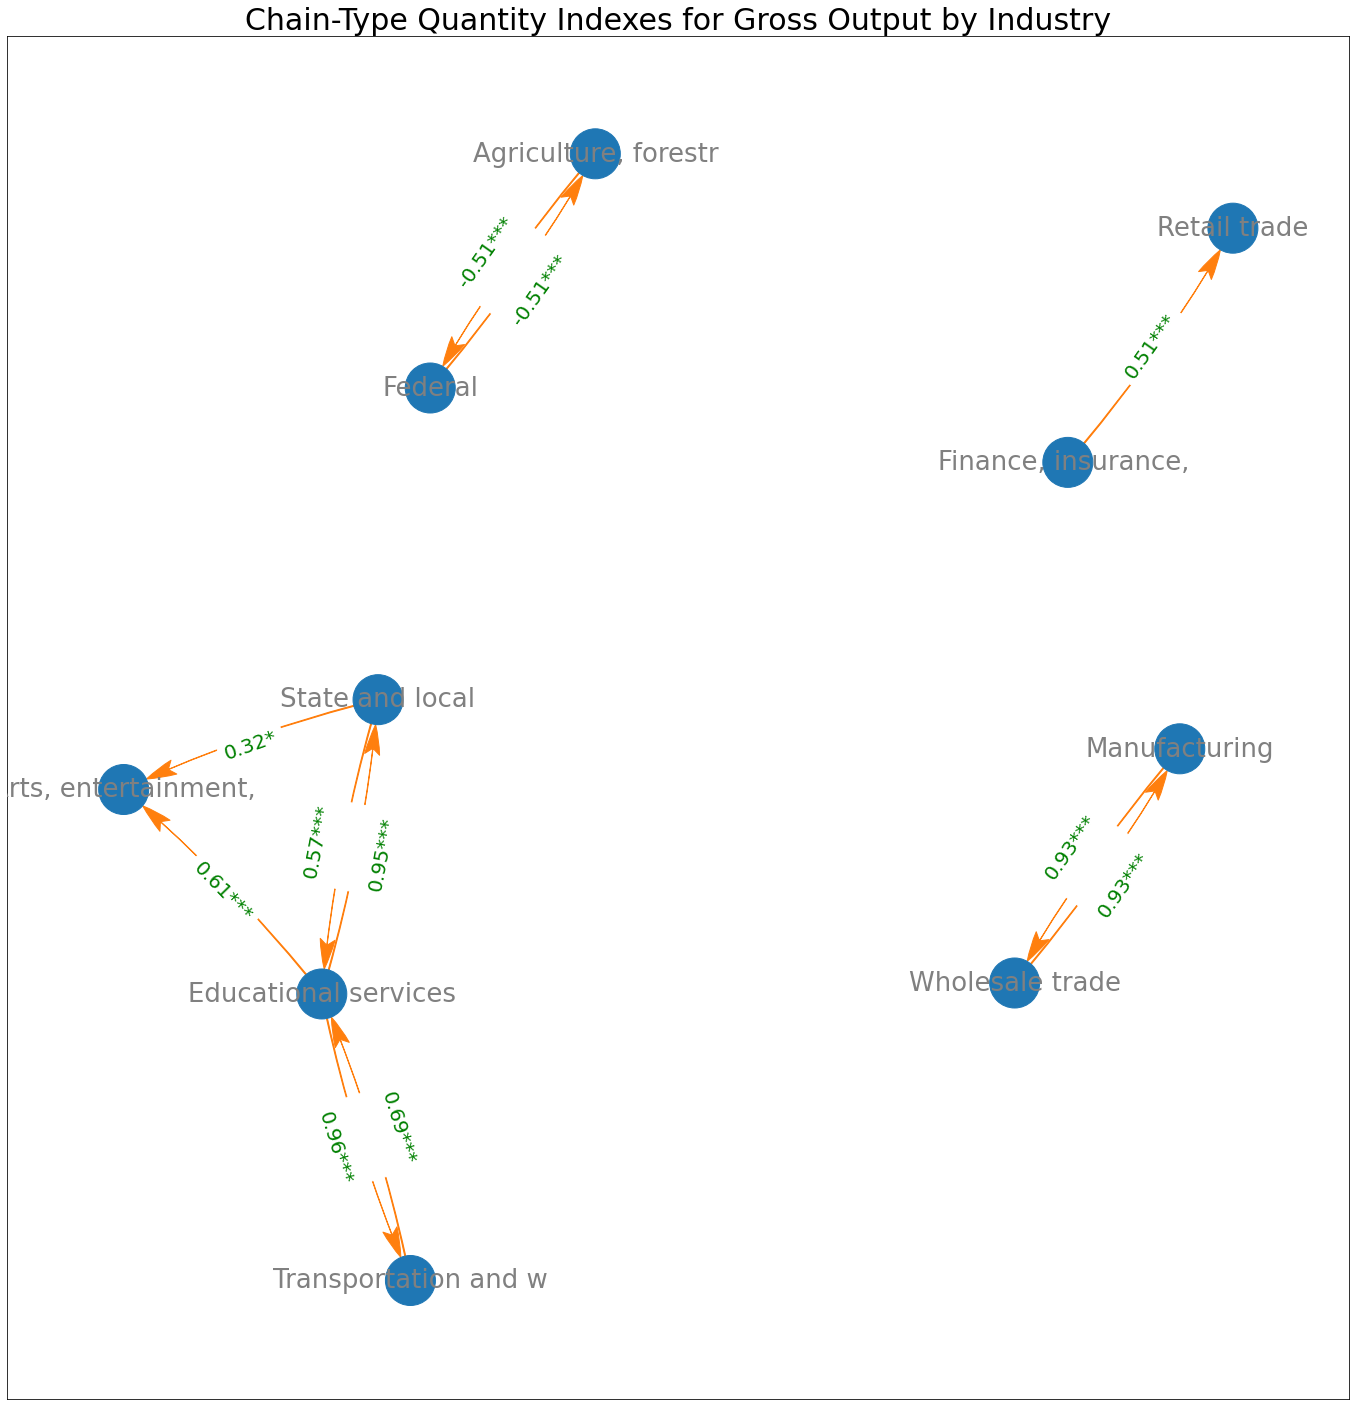

Working for n conditional variables: 4:  31%|█████████████▏                             | 4/13 [00:00<00:02,  4.29it/s]


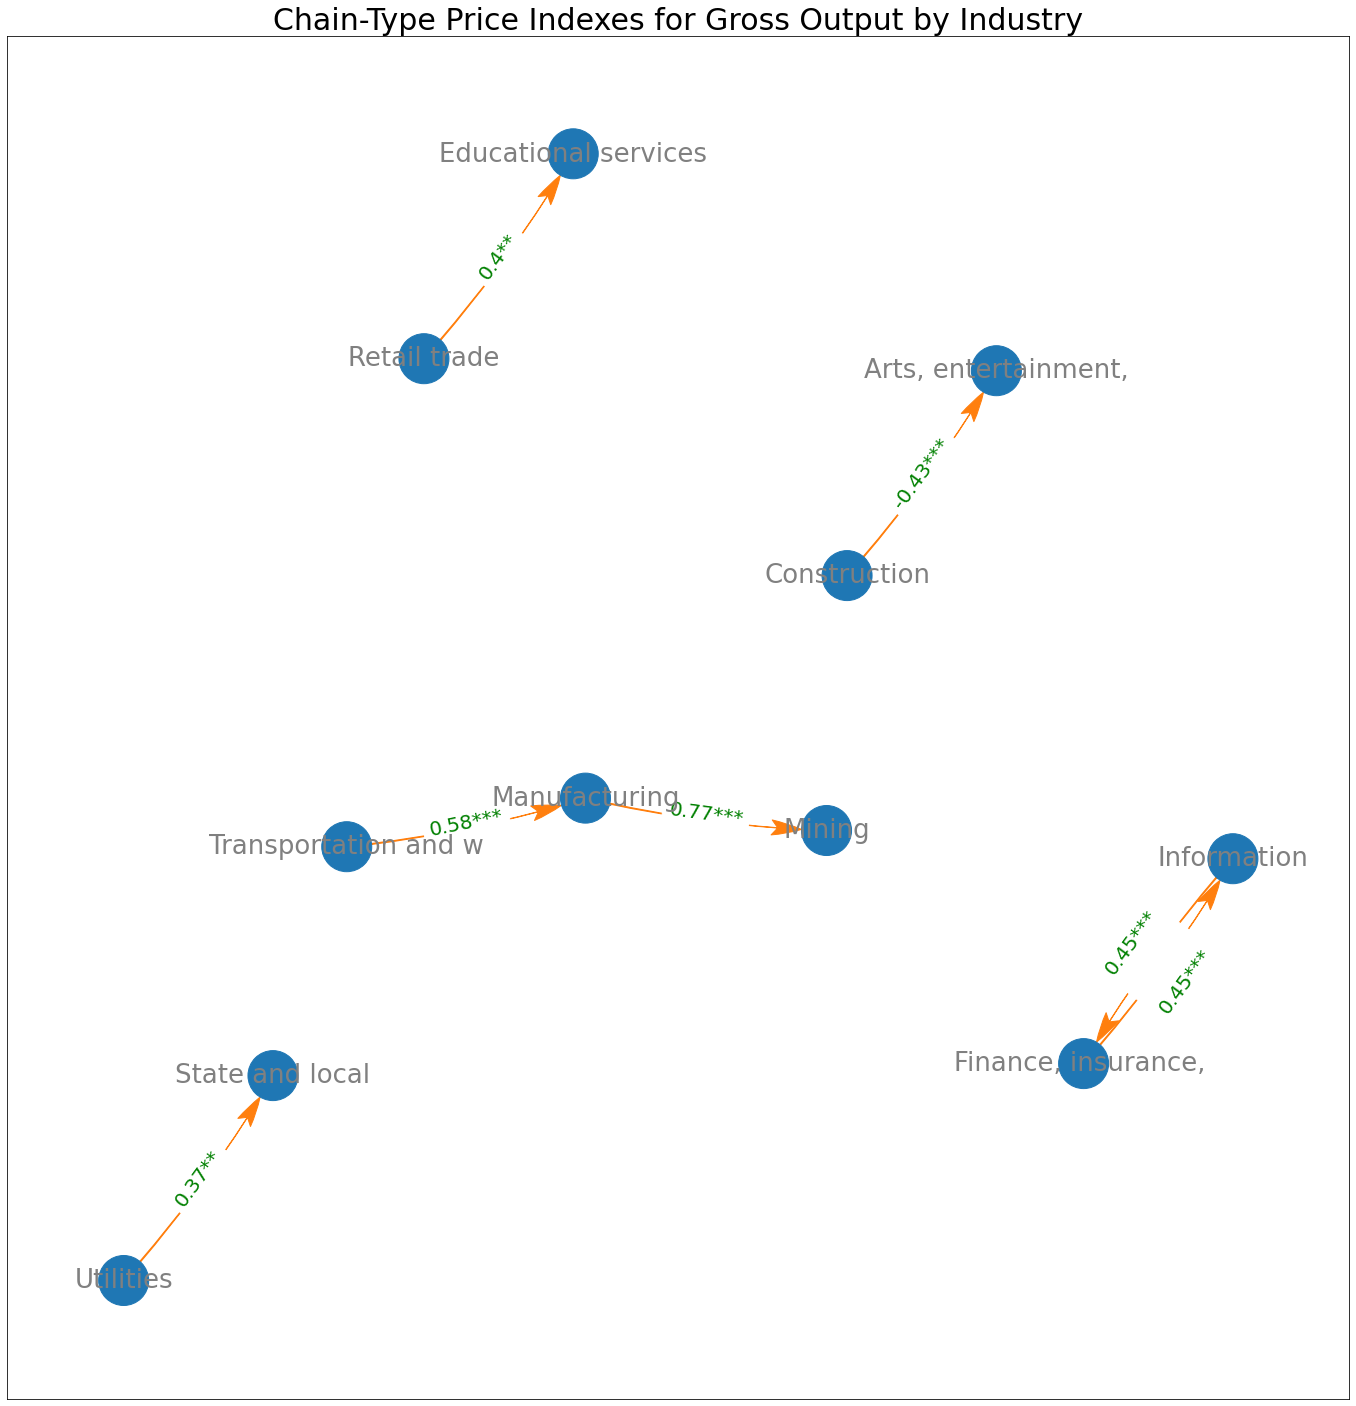

Working for n conditional variables: 4:  31%|█████████████▏                             | 4/13 [00:02<00:05,  1.74it/s]


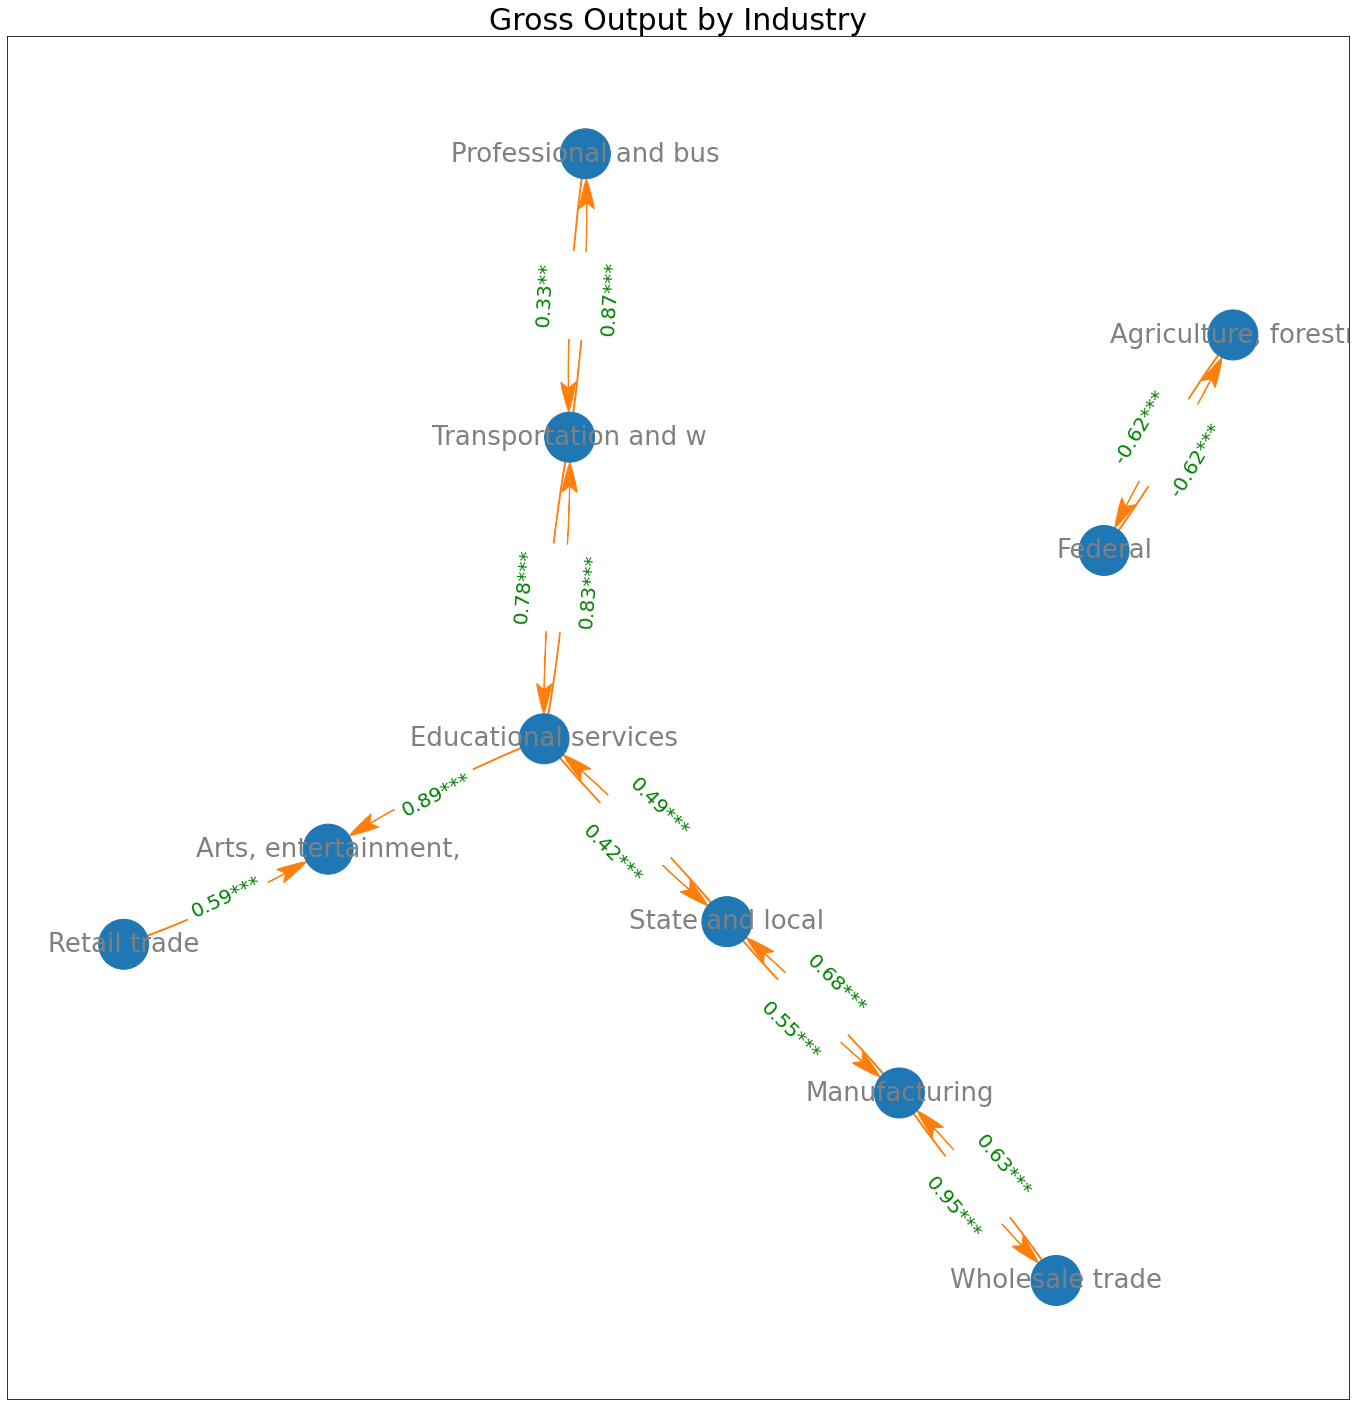

Working for n conditional variables: 4:  31%|█████████████▏                             | 4/13 [00:02<00:05,  1.72it/s]


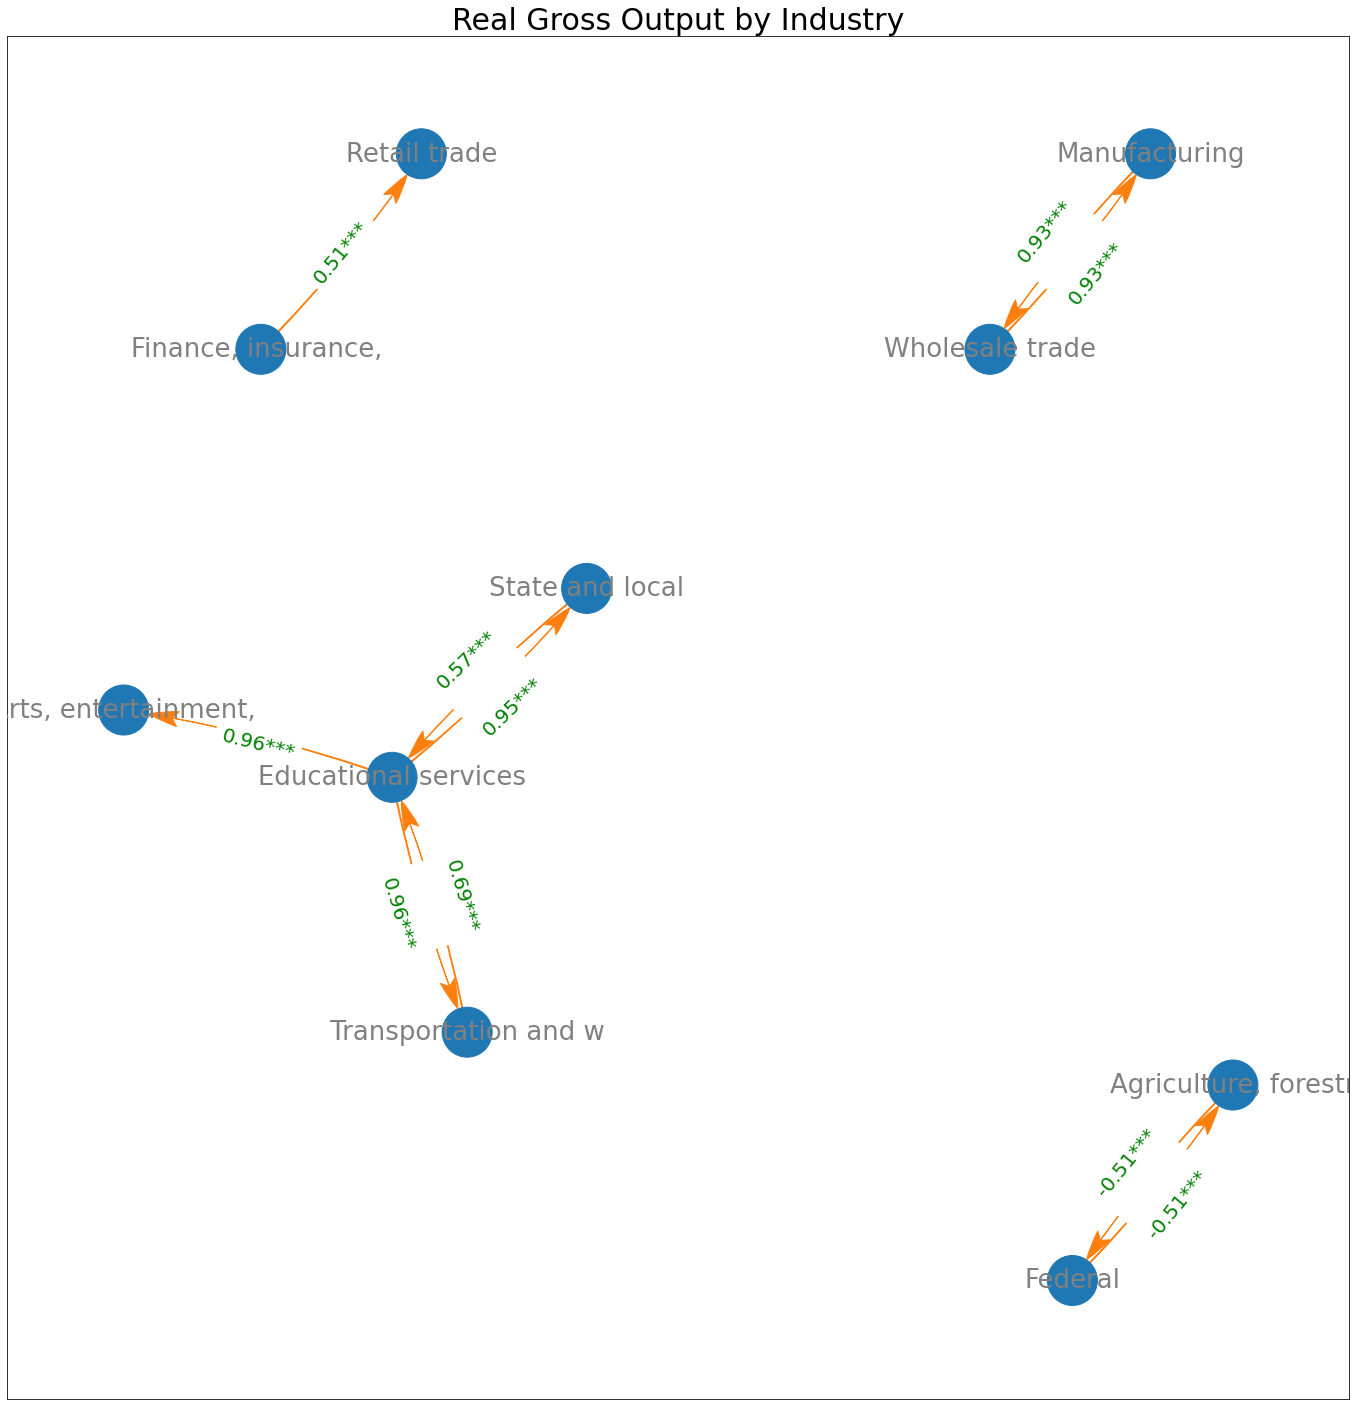

In [20]:
import pingouin
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sn
from matplotlib.patches import Rectangle
from pgmpy.estimators import PC
from pgmpy.base import DAG
import matplotlib.pyplot as plt
from matplotlib.patches import ArrowStyle
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
plt.rcParams.update({"font.size":20})

def graph_DAG(edges, 
              df, 
              pp, 
              edge_labels = False, 
              sig_vals = [.05,.01,.001],
              title = ""):
    def build_edge_labels(edges, df, sig_vals):
        edge_labels = {}
        for edge in edges:
            controls = [key for key in df.keys() if key not in edge]
            controls = list(set(controls))
            keep_controls = []
            for control in controls:
                control_edges = [ctrl_edge for ctrl_edge in edges if control == ctrl_edge[0] ]
                if (control, edge[1]) in control_edges:
                    keep_controls.append(control)                
            pcorr = df.partial_corr(x = edge[0], y = edge[1], covar=keep_controls,
                                  method = "pearson")
            label = str(round(pcorr["r"][0],2))
            pvalue = pcorr["p-val"][0]
#             pcorr = df[[edge[0], edge[1]]+keep_controls].pcorr()
#             label = pcorr[edge[0]].loc[edge[1]]

            for sig_val in sig_vals:
                if pvalue < sig_val: 
                    label = label + "*"   
            
            edge_labels[edge] = label
        return edge_labels
    graph = nx.DiGraph()
    if edge_labels == False:
        edge_labels = build_edge_labels(edges, 
                                        df, 
                                        sig_vals=sig_vals) 
    graph.add_edges_from(edges)
    color_map = ["C0" for g in graph]

    fig, ax = plt.subplots(figsize = (20,20))
    graph.nodes()
    plt.tight_layout()
    pos = graphviz_layout(graph)

    nx.draw_networkx(graph, pos, node_color=color_map, node_size = 2500,
                     with_labels=True,  arrows=True,
                     font_color = "grey",
                     font_size = 26, alpha = 1,
                     width = 1, edge_color = "C1",
                     arrowstyle=ArrowStyle("Fancy, head_length=3, head_width=1.5, tail_width=.1"),
                     connectionstyle='arc3, rad = 0.05',
                     ax = ax)
    
    plt.title(title, fontsize = 30)
    edge_labels2 = []
    for u, v, d in graph.edges(data=True):
        if pos[u][0] > pos[v][0]:  
            if (v,u) in edge_labels.keys():
                edge_labels2.append(((u, v,), f'{edge_labels[u,v]}\n\n\n{edge_labels[(v,u)]}'))  
        if (v,u) not in edge_labels.keys():
            edge_labels2.append(((u,v,), f'{edge_labels[(u,v)]}'))
    edge_labels = dict(edge_labels2)

    nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels, font_color='C2')
    
    nx.draw_networkx_edge_labels(graph,pos,
                                 edge_labels=edge_labels,
                                 font_color='green',
                                 font_size=20)
    pp.savefig(fig, bbox_inches = "tight")  
    plt.show()
    plt.close()

def DAG(dag_data, variant, ci_test, sig, return_type = "dag"):
    c = PC(dag_data)
#     edges = c.skeleton_to_pdag(*c.build_skeleton())
    max_cond_vars = len(dag_data.keys()) - 2
    model = c.estimate(return_type = return_type,
                       variant= variant, 
                       significance_level = sig, 
                       max_cond_vars = max_cond_vars, 
                       ci_test = ci_test)
    edges = model.edges()
    
    return edges
    
def calculate_pcorr(data, keys):
    pcorr_df = data[keys]

    pcorr_dct = {}
    p_val_dct = {}
    for key1 in keys:
        p_val_dct[key1] = {}
        pcorr_dct[key1] = {}
        for key2 in keys:
            if key1 != key2:
                other_vars = [z for z in pcorr_df.keys() if z != key1 and z != key2 ]
                stats = pingouin.partial_corr(data=pcorr_df, 
                                              x = key1, 
                                              y = key2, 
                                              covars=other_vars)
                p_val_dct[key1][key2] = stats["p-val"].values[0]

                pcorr_dct[key1][key2] = pcorr_df.pcorr()[key1][key2]
            else:
                p_val_dct[key1][key2] = 1
                pcorr_dct[key1][key2] = 1

    p_val_df = pd.DataFrame(p_val_dct)
    pcorr_df = pd.DataFrame(pcorr_dct)
    return pcorr_df, p_val_df


for group in layers:
    pp = PdfPages(group + "corrPlots.pdf")
    df = sector_data[group]
    keys = layers[group][1]["Private industries"] + layers[group][1]["Government"]
    df = df[keys].pct_change(1).diff(1).diff(1)
    pcorr_df, p_val_df = calculate_pcorr(df, keys)

    plot_df = pcorr_df.dropna()
    plot_pvals_df = p_val_df.dropna()

    sig_vals = [.05, .01, .001]
    for key in plot_df:
        plot_df[key] = plot_df[key].round(3).astype(str)
        #plot_pvals_df[key] = plot_pvals_df[key].astype(str)
        for ix in plot_df.index:
            value = plot_df.loc[ix, key]
            p_val = plot_pvals_df.loc[ix, key]
            for sig_val in sig_vals:
                if p_val < sig_val: 
                    plot_df.loc[ix,key] = plot_df.loc[ix, key] + "*"

    plot_df = pcorr_df.dropna()

    plt.rcParams.update({'font.size': 20}) 

    # pcorr_df.style.use(p_val_df.style.applymap(bold_sig).export())
    fig, ax = plt.subplots(figsize = (50,50))
    mx = np.abs(pcorr_df.max().max())
    mn = np.abs(pcorr_df.min().min())
    max_val = max([mx,mn])
    min_val = max_val * -1
    pcorr_plot_df = plot_df.rename(columns = {key:key.replace("  ", "").replace(" ", "\n") for key in plot_df.keys()}, index = {ix:ix.replace("  ", "").replace(" ", "\n") for ix in plot_df.index})
    
    countries = plot_df.index
    keys = plot_df.keys()
    mp = sn.heatmap(pcorr_plot_df, annot = True, linewidth=1,cmap = "seismic", ax=ax, vmin=min_val, vmax=max_val)
    plt.title("Partial Correlation\n"+group, fontsize = 50)
    for i in range(len(keys)):
        for j in range(len(countries)):
            key = keys[i]
            country = countries[j]
            p_val = p_val_df.loc[country][key]
            lw = 0
            for k in range(len(sig_vals)):
                sig_val = sig_vals[k]
                if p_val <= sig_val:
                    lw = 3 * (k + 1) ** 2
    #         anchor = (lw / 2, lw / 2)
            mp.add_patch(Rectangle((i, j), 1, 1, fill=False, edgecolor='k', lw=lw))
#     plt.show()
    plt.close()
    
    try:
        dag_df = df.dropna()[private_and_public]
    except:
        private_and_public.remove('  Other services, except government')
        dag_df = df.dropna()[private_and_public]

    
    dag_df.rename(
        columns={
            col:col.replace("  ", "")[:20] for col in dag_df.keys()}, 
        inplace = True)
    variant = "parallel"
    sig = 0.05
    ci_test = "pearsonr"
    keys = dag_df.keys()
    edges = DAG(dag_df, variant, ci_test, sig, return_type = "pdag")
    graph_DAG(edges, dag_df, title = group, pp = pp)    
# pcorr_df[p_val_df["General Outcome"] < sig]#.style.apply(highlight)
# pcorrsig[p_val_df["General Outcome"] < sig].to_csv("StatisticallySignificantOutcomesbyCountry.csv")
# p_val_df[p_val_df["General Outcome"] < sig].to_csv("StatisticalSignificancebyCountry.csv")